In [132]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats import linregress

# Calibrating Frequency / Voltage

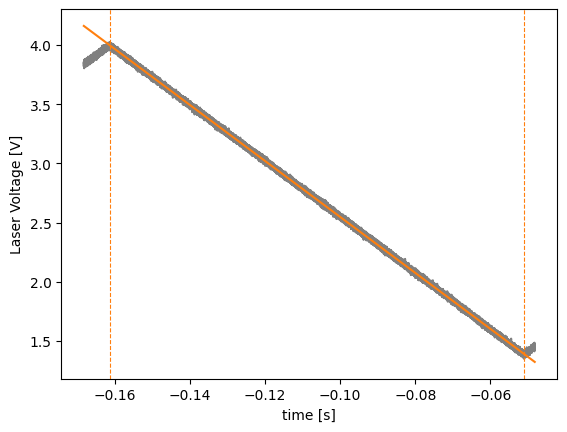

In [133]:
dataframe = read_csv("4_4_1-V2.CSV", names=["t","c1", "c2"])    
dataframe.drop(dataframe.index[[0]], inplace=True)
dataframe = dataframe.astype(float)

data = dataframe.values
t, c1, c2 = data[:, 0], data[:, 1], data[:, 2]

# linear regression for voltage curve
voltage_sweep_bounds = (np.argmax(c1), np.argmin(c1))
m, c, _, _, _ = linregress(t[voltage_sweep_bounds[0]:voltage_sweep_bounds[1]], c1[voltage_sweep_bounds[0]:voltage_sweep_bounds[1]])
c1_linearised = m * t + c

plt.plot(t, c1, color='gray')
plt.plot(t, c1_linearised, color='C1')

plt.xlabel("time [s]")
plt.ylabel("Laser Voltage [V]")

for bound in voltage_sweep_bounds:
    plt.axvline(t[bound], linestyle='--', c='C1', linewidth=0.8)

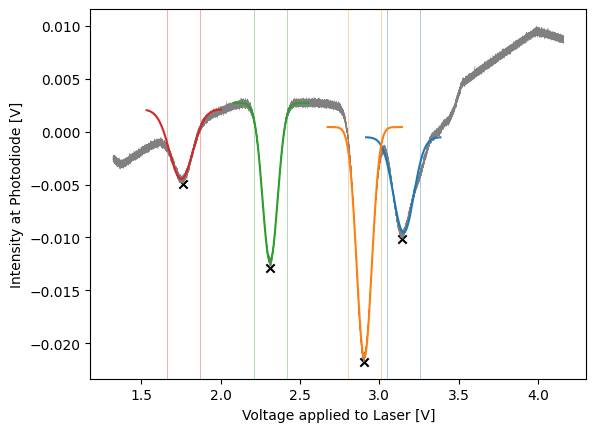

In [134]:
# Find peaks (without gaussians)
peaks = find_peaks(-c2, height=0.004, distance=10000)[0]
xpeaks = np.array([c1_linearised[i] for i in peaks])
ypeaks = np.array([c2[i] for i in peaks])

# voltage at peaks (not good cause of voltage jitter, should fit a straight line first)
peakVoltages = np.array([c1[i] for i in peaks])

# fit gaussian to each peak
peak_width = 5000 # given in number of neighbouring datapoints
peak_skew_factor = 1.8 # > 1 shifts boundaries further right
gaussian_fit_boundaries = [(int(i - peak_width), int(i + peak_skew_factor * peak_width / 2)) for i in peaks]

# fit function
def gaussian(vL, A, v0, vD, DC_offset):
	return - A * np.exp(-4 * np.log(2) * pow((vL - v0) / vD, 2)) + DC_offset

# fitting and plotting
peak_info = []
for i, (LB, UB) in enumerate(gaussian_fit_boundaries):
    initialguess = 0.003, xpeaks[i], 0.01 / 2, 0.1
    (A, v0, vD, DC_offset), _ = curve_fit(gaussian, c1_linearised[LB:UB], c2[LB:UB], initialguess)

    plot_boundary_extension = 6000
    x_gaussian_fit = np.linspace(c1_linearised[LB-plot_boundary_extension], c1_linearised[UB+plot_boundary_extension], num=1000)
    y_gaussian_fit = gaussian(x_gaussian_fit, A, v0, vD, DC_offset)

    plt.plot(x_gaussian_fit, y_gaussian_fit, '-', c='C'+str(i), zorder=100)

    # add peak frequency and FWHM to peak_info list
    peak_info.append((v0, vD))

#plot original signal
plt.scatter(xpeaks, ypeaks, marker='x', c='black')
plt.plot(c1_linearised[::1], c2[::1], linewidth=0.2, c='gray')
plt.ylabel("Intensity at Photodiode [V]")
plt.xlabel("Voltage applied to Laser [V]")

# plot gaussian_fit_boundaries
for peak_number, boundaries in enumerate(gaussian_fit_boundaries):
    for bound in boundaries:
        plt.axvline(x=c1_linearised[bound], color='C'+ str(peak_number), alpha=0.5, linewidth=0.5)

-4893640616.324474

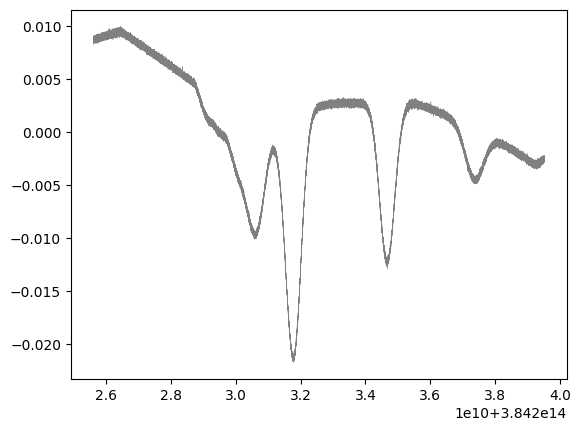

In [135]:
f0 = 384.2304844685e12
f1 = f0 + 1.296117462789e9
f2 = f1 + 3.035732439e9 
f3 = f2 + 2.500832709015e9
peakFrequencies = np.array([f0,f1,f2,f3])
peakVoltages = [v for (v, _) in peak_info] 
df_dv, intercept, _, _, _ = linregress(peakVoltages, peakFrequencies)

freq = c1_linearised * df_dv + intercept
plt.plot(freq[::1], c2[::1], linewidth=0.3, c='gray')
df_dv

Text(0, 0.5, 'True peak frequencies [Hz]')

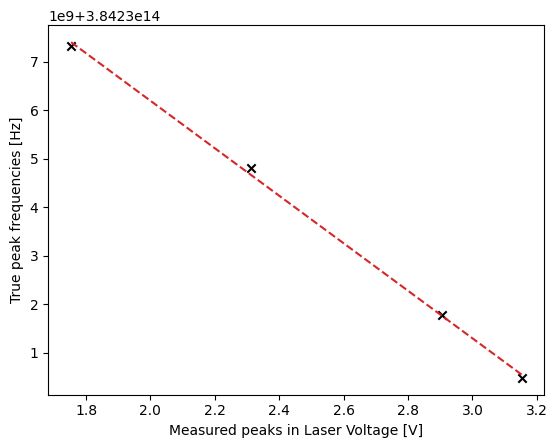

In [136]:
plt.scatter(peakVoltages, peakFrequencies, marker='x', c='black')
plt.plot(peakVoltages, df_dv * np.array(peakVoltages) + intercept, linestyle='--', c='C3')
plt.xlabel("Measured peaks in Laser Voltage [V]")
plt.ylabel("True peak frequencies [Hz]")

# UMF peak 2

Text(0, 0.5, 'Laser Voltage [V]')

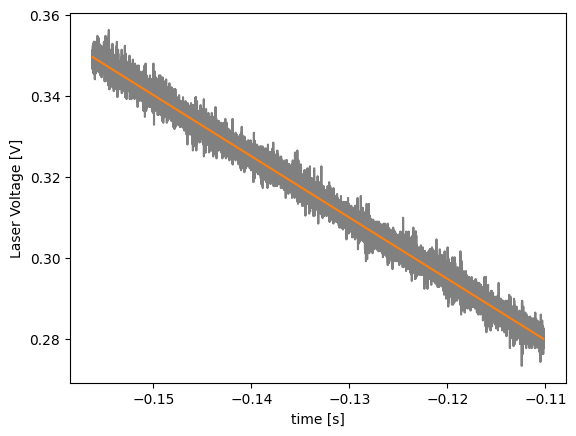

In [137]:
dataframe = read_csv("UMF_2.CSV", names=["t","c1", "c2"])    
dataframe.drop(dataframe.index[[0]], inplace=True)
dataframe = dataframe.astype(float)

data = dataframe.values
top_trim = 70000
bottom_trim = 20000
t, c1, c2 = data[bottom_trim:top_trim, 0], data[bottom_trim:top_trim, 1], data[bottom_trim:top_trim, 2]

# linear regression for voltage curve)
m, c, _, _, _ = linregress(t, c1)
c1_linearised = m * t + c

plt.plot(t, c1, color='gray')
plt.plot(t, c1_linearised, color='C1')

plt.xlabel("time [s]")
plt.ylabel("Laser Voltage [V]")


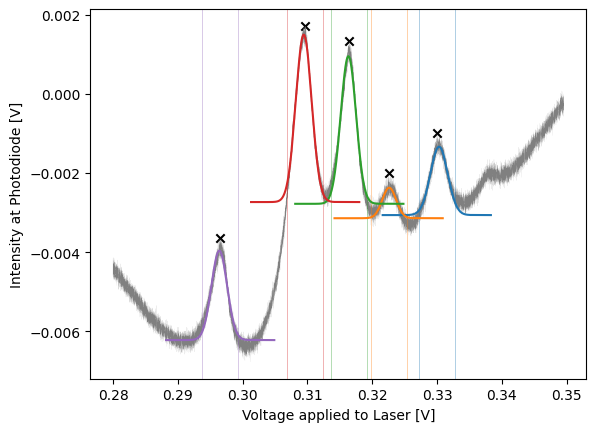

In [138]:
# Find peaks (without gaussians)
peaks = find_peaks(c2, height=-0.004, distance=1000, width=300)[0]
xpeaks = np.array([c1_linearised[i] for i in peaks])
ypeaks = np.array([c2[i] for i in peaks])

# voltage at peaks (not good cause of voltage jitter, should fit a straight line first)
peakVoltages = np.array([c1[i] for i in peaks])

# fit gaussian to each peak
peak_width = 2000 # given in number of neighbouring datapoints
peak_width_shift = 1000 # > 1 shifts boundaries further left
gaussian_fit_boundaries = [(int(i - peak_width_shift - peak_width / 2), int(i + peak_width_shift + peak_width / 2)) for i in peaks]

# fit function
def gaussian(vL, A, v0, vD, DC_offset):
	return A * np.exp(-4 * np.log(2) * pow((vL - v0) / vD, 2)) + DC_offset

peak_info =[]
# fitting and plotting

for i, (LB, UB) in enumerate(gaussian_fit_boundaries):
    initialguess = 0.03, xpeaks[i], 0.01 / 2, -0.001
    (A, v0, vD, DC_offset), _ = curve_fit(gaussian, c1_linearised[LB:UB], c2[LB:UB], initialguess)

    plot_boundary_extension = 4000
    x_gaussian_fit = np.linspace(c1_linearised[LB-plot_boundary_extension], c1_linearised[UB+plot_boundary_extension], num=1000)
    y_gaussian_fit = gaussian(x_gaussian_fit, A, v0, vD, DC_offset)

    plt.plot(x_gaussian_fit, y_gaussian_fit, '-', c='C'+str(i), zorder=100)

    # add peak frequency and FWHM to peak_info list
    peak_info.append((v0, vD))

#plot original signal
plt.scatter(xpeaks, ypeaks, marker='x', c='black')
plt.plot(c1_linearised[::1], c2[::1], linewidth=0.05, c='gray')
plt.ylabel("Intensity at Photodiode [V]")
plt.xlabel("Voltage applied to Laser [V]")
# plot gaussian_fit_boundaries
for peak_number, boundaries in enumerate(gaussian_fit_boundaries):
    for bound in boundaries:
        plt.axvline(x=c1_linearised[bound], color='C'+ str(peak_number), alpha=0.5, linewidth=0.5)


# UMF peak 3

Text(0, 0.5, 'Laser Voltage [V]')

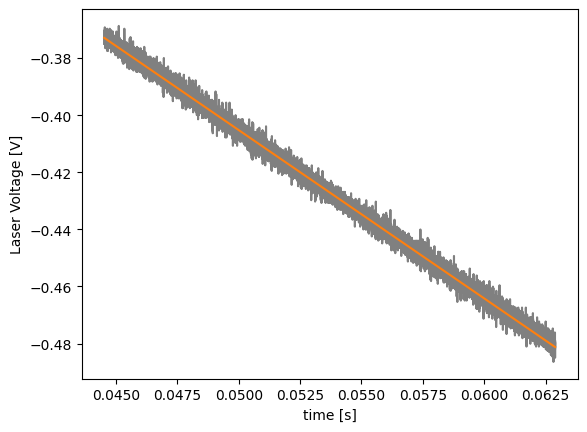

In [139]:
dataframe = read_csv("UMF_3.CSV", names=["t","c1", "c2"])    
dataframe.drop(dataframe.index[[0]], inplace=True)
dataframe = dataframe.astype(float)

data = dataframe.values
top_trim = 80000
bottom_trim = 40000
t, c1, c2 = data[bottom_trim:top_trim, 0], data[bottom_trim:top_trim, 1], data[bottom_trim:top_trim, 2]

# linear regression for voltage curve
m, c, _, _, _ = linregress(t, c1)
c1_linearised = m * t + c

plt.plot(t, c1, color='gray')
plt.plot(t, c1_linearised, color='C1')

plt.xlabel("time [s]")
plt.ylabel("Laser Voltage [V]")


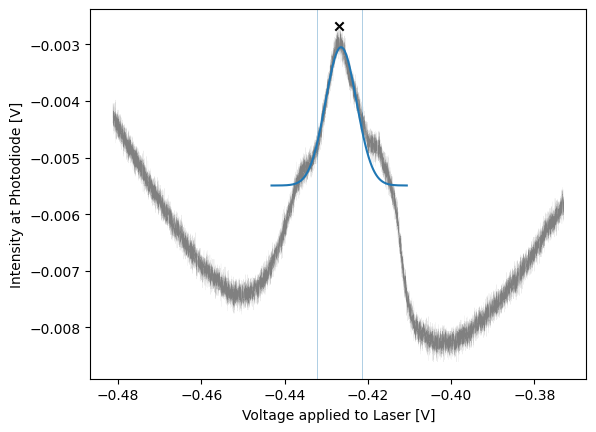

In [140]:
# Find peaks (without gaussians)
peaks = find_peaks(c2, height=-0.004, distance=1000, width=300)[0]
xpeaks = np.array([c1_linearised[i] for i in peaks])
ypeaks = np.array([c2[i] for i in peaks])

# voltage at peaks (not good cause of voltage jitter, should fit a straight line first)
peakVoltages = np.array([c1[i] for i in peaks])

# fit gaussian to each peak
peak_width = 2000 # given in number of neighbouring datapoints
peak_width_shift = 1000 # > 1 shifts boundaries further left
gaussian_fit_boundaries = [(int(i - peak_width_shift - peak_width / 2), int(i + peak_width_shift + peak_width / 2)) for i in peaks]

# fit function
def gaussian(vL, A, v0, vD, DC_offset):
	return A * np.exp(-4 * np.log(2) * pow((vL - v0) / vD, 2)) + DC_offset

peak_info =[]
# fitting and plotting

for i, (LB, UB) in enumerate(gaussian_fit_boundaries):
    initialguess = 0.03, xpeaks[i], 0.01 / 2, -0.001
    (A, v0, vD, DC_offset), _ = curve_fit(gaussian, c1_linearised[LB:UB], c2[LB:UB], initialguess)

    plot_boundary_extension = 4000
    x_gaussian_fit = np.linspace(c1_linearised[LB-plot_boundary_extension], c1_linearised[UB+plot_boundary_extension], num=1000)
    y_gaussian_fit = gaussian(x_gaussian_fit, A, v0, vD, DC_offset)

    plt.plot(x_gaussian_fit, y_gaussian_fit, '-', c='C'+str(i), zorder=100)

    # add peak frequency and FWHM to peak_info list
    peak_info.append((v0, vD))

#plot original signal
plt.scatter(xpeaks, ypeaks, marker='x', c='black')
plt.plot(c1_linearised[::1], c2[::1], linewidth=0.05, c='gray')
plt.ylabel("Intensity at Photodiode [V]")
plt.xlabel("Voltage applied to Laser [V]")
# plot gaussian_fit_boundaries
for peak_number, boundaries in enumerate(gaussian_fit_boundaries):
    for bound in boundaries:
        plt.axvline(x=c1_linearised[bound], color='C'+ str(peak_number), alpha=0.5, linewidth=0.5)
